Active Contours using Level Sets
================================

## ROIG Lila, GONZALEZ Julie, ETHEVE Eva, CAMUSAT Léa, 5MA A
*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$

<font color='blue'> **Objectif du projet :**
    
    
<font color='blue'> L'objectif de ce TP est de mettre en oeuvre des modèles de contour actif. On cherche à approximer les contours d'une forme donnée avec une fonction suffisamment régulière.

<font color='blue'> Nous employons l'approche par les courbes de niveau. En effet, celles ci permettent de détecter le contour d'une figure par son changement de signe. A l'intérieur de la figure, les courbes de niveaux ont des valeurs négatives. A l'extérieur de la figure, elles ont des valeurs positives. Ainsi, lorsque la courbe de niveau atteint le 0, on a trouvé le contour de la figure. 
    

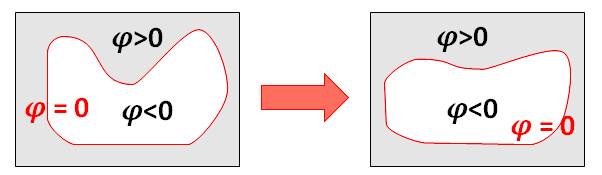

This tour explores image segementation using level set methods.

In [1]:
from __future__ import division

import numpy as np
import scipy as scp
import pylab as pyl
import matplotlib.pyplot as plt

from nt_toolbox.general import *
from nt_toolbox.signal import *

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

Managing level set functions
----------------------------
In the level set formalism, the evolution of some curve $ (\ga(t))_{t=0}^1 $
is computed by evolving the
zero level of a function $\phi : \RR^2 \rightarrow \RR $
$$ \enscond{\ga(s)}{ s \in [0,1] } = \enscond{x \in \RR^2}{\phi(x)=0}. $$
This corresponds to replacing the parameteric representation $\ga$ of
the curve by an implicit representation. This requires an additional
dimension (and hence more storage) but ease the handling of topological
change of the curve during the evolution.


Discretazion size $n \times n$ of the domain $[0,1]^2$.


<font color = "blue"> **Rappels :** Une courbe peut être décrite par sa représentation paramétrique ou par sa représentation cartésienne. 
Dans la forme paramétrique, les points de la courbe sont exprimés en fonction d'une variable réelle, conventionnellement notée t représentant le temps: $(\gamma(t))_{t=0}^1$. La représentation cartésienne est une équation qui décrit les relations entre les coordonnées des points de la courbe. 
    Cette représentation peut être implicite, comme par exemple : 
    $ \varphi(x_1,x_2) = \sqrt{ (x_1-c_1)^2 + (x_2-c_2)^2 } - r = 0 $ (équation d'un cercle)\
    ou explicite :  $\varphi(x_2) = c_2 \pm \sqrt{r - (x_1 - c_1)^2}  $ 

<font color = "blue"> Les représentations cartésiennes et paramétriques sont équivalentes : 
$\{ \gamma (s),  s \in [0,1] \}$ = $\{x \in \mathbb{R}^n, \varphi(x)=0\}$
    


In [2]:
n = 200
# Création d'une grille de taille n*n
Y,X = np.meshgrid(np.arange(1,n+1), np.arange(1,n+1)) 

**Définition des éléments pour la création du cercle :**

One can create a circular shape by using the signed distance function to
a circle
$$ \phi_1(x) = \sqrt{ (x_1-c_1)^2 + (x_2-c_2)^2 } - r $$
where $r>0$ is the radius and $c \in \RR^2$ the center.


Radius $r$.

In [3]:
r = n/3.

Center $c$.

In [4]:
c = np.array([r,r]) + 10

Distance function $\phi_1$.

In [5]:
phi1 = np.sqrt((X-c[0])**2 + (Y-c[1])**2) - r

__Exercise 1__

**Définition des éléments pour la création du carré :**

Load a square shape $\phi_2$ at a different position for the center : $\phi_2(x) = ||x-c||_{\infty}-r = max(|x_1-c_1|,|x_2-c_2|) - r $

In [6]:
# Définition d'un nouveau centre pour le carré 

# on déplace le centre du carré : 
shift_x = 30
shift_y = 30
c2 = [c[0] + shift_x , c [1] + shift_y] # centre du carré

# Définition de la fonction phi2(x)
phi2 =  np.maximum(abs(X-c2[0]), abs(Y-c2[1])) - r

Display the curves associated to $\phi_1$ and $\phi_2$.

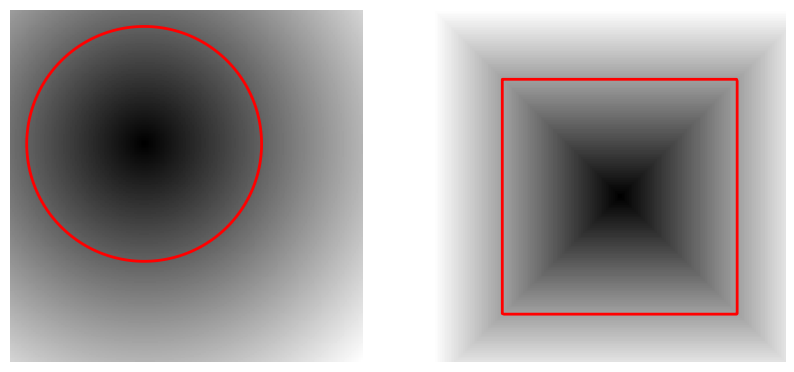

In [7]:
from nt_toolbox.plot_levelset import *

#plot_levelset utilise un meshgrid de même taille que les valeurs de la fonction (ici phi1) 
#phi1 correspond aux valeurs de hauteur sur lesquelles le contour est dessiné. La forme 
# est en niveaux (M, N): détermine le nombre et les positions des lignes de contour/régions.
plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
plot_levelset(phi1)

plt.subplot(1,2,2)
plot_levelset(phi2)

__Exercise 2__

Compute the intersection and the union of the two shapes.
Store the union in $\phi_0$ (phi0)
that we will use in the remaining part of the tour.  

<font color = "blue"> L'image ci-dessous illustre l'obtention de l'intersection et de l'union de deux courbes de niveau. 
- <font color = "blue"> L'intersection correspond au maximum des deux courbes
- <font color = "blue"> L'union correspond au minimum des deux courbes
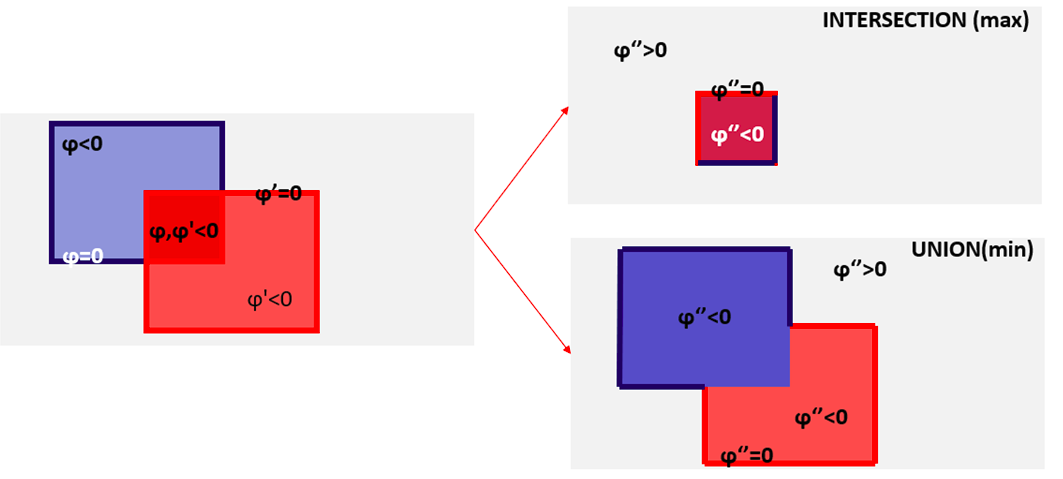

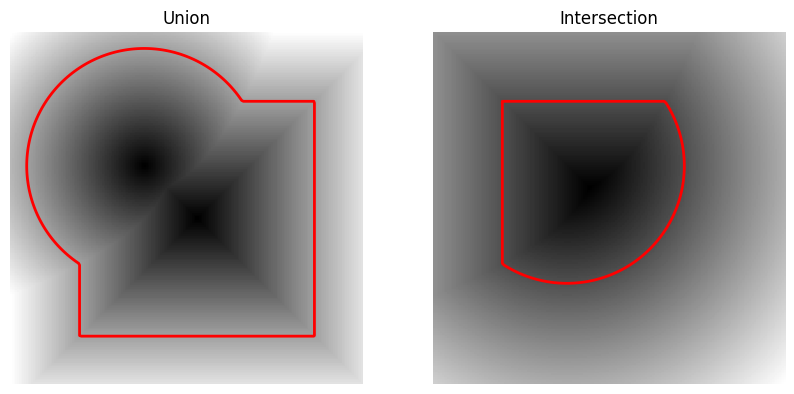

In [8]:
## Insert your code here.
plt.figure(figsize = (10,5))

plt.subplot(121)
plt.title("Union")
plot_levelset(np.minimum(phi1, phi2))

plt.subplot(122)
plt.title("Intersection")
plot_levelset(np.maximum(phi1, phi2))

plt.show()

Mean Curvature Motion.
----------------------
The mean curvature motion corresponds to the minimizing flow of the
length of the curve
$$ E =\int_0^1 \norm{\ga'(s)} d s. $$

It is implemeted in a level set formalism by a familly $\phi_t$ of
level set function parameterized by an artificial time $t \geq 0$, that
satisfies the following PDE
$$ \pd{\phi_t}{t} = -G(\phi_t)
  \qwhereq G(\phi) = -\norm{\nabla \phi} \text{div}
      \pa{  \frac{\nabla \phi}{\norm{\nabla \phi}} }  $$
and where $\nabla \phi_t(x) \in \RR^2$ is the spacial gradient.


This flow is computed using a gradient descent
$\phi^{(0)} = \phi_0$ and
$$ \phi^{(\ell+1)} = \phi^{(\ell)} - \tau G(\phi^{(\ell)}), $$
where $\tau>0$ is small enough time step. 


<font color='blue'> **Explication du problème :**
    
    
<font color='blue'>    - On cherche à approximer le contour de l'union ou de l'intersection entre deux formes par une courbe de niveau qui soit suffisamment régulière. Par exemple, quand on prend l'union du cercle et du carré sur l'image précédente, le contour obtenu à la jonction des deux formes est irrégulier, il a des angles que l'on voudrait adoucir en contraignanat la courbe de niveau à devenir plus régulière.
    
<font color='blue'>    - Résoudre le problème d'optimisation, c'est-à-dire trouver le minimum de E, permet de forcer la courbe de niveau qui fait l'union entre les deux formes à devenir plus régulière. 
<font color = "blue"> E s'appelle "curve length" (longueur de la courbe), elle correspond à la fonction énergie interne que l'on veut minimiser. En effet, elle caractérise la régularité de la courbe. Par exemple, si la fonction est très irrégulière, alors la norme des dérivées $\gamma' (s)$ sera très grande et donc l'intégrale E augmentera fortement. Ainsi, plus on minimise E, plus on force la fonction à devenir lisse. 

<font color = "blue"> On minimise E en faisant une descente de gradient, où $\varphi_t$ est la valeur de la courbe de niveau à l'itération $t$ : 

<font color='blue'>  $$ \varphi_{t+1} = \varphi_t - \tau G(\varphi_t) $$


<font color='blue'>  où $\tau$ est le pas et la direction de descente G est définie par 

<font color='blue'> $$ G(\varphi_t) = - \frac{\partial}{\partial t}\varphi_t = - \text{div} \pa{  \frac{\nabla \varphi_t}{\|\nabla\varphi_t\|} } . \|\nabla \varphi_t\| $$

<font color='blue'> avec $\nabla \varphi_t$  est le gradient spatial de $\varphi_t$.
    
    
<font color='blue'>    - A chaque itération de la descente de gradient, on met à jour la courbe de niveau en se déplaçant dans la direction opposée au gradient pour minimiser la valeur de E et donc augmenter la régularité de la courbe de niveau. 

    
</font>

<font color='blue'>

On définit un à un les éléments dont on va avoir besoin pour réaliser la descente de gradient. 
    
Pour la descente de gradient, on définit les constantes suivantes : 
- Tmax : Temps maximal de l'évolution : $0 \leq t \leq t_{\max}$.
- tau : Pas de la descente de gradient $\tau>0$ (doit être petit).
- niter : Nombre d'itérations maximales.
    
</font>

In [9]:
Tmax = 200 # un critère sur le nombre maximal d'itération
tau = .5 # le pas de la descente de gradient
niter = int(Tmax/tau) # on définit un critère sur le nombre maximal d'itération

<font color = "blue"> Initialisation du point de départ : on part de l'union des deux formes (à changer, tester aussi l'intersection)

In [10]:
phi0 = np.minimum(phi1, phi2)
phi = np.copy(phi0)

We now compute the right hand side of the evolution equation.


<font color = "blue"> On calcule le gradient $\nabla \phi$. On utilise les différences centrées pour la discrétisation du gradient.

In [11]:
from nt_toolbox.grad import *
g0 = grad(phi, order=2)

<font color = "blue"> On calcule la norme $\norm{\nabla \phi}$ du gradient.

In [12]:
eps = np.finfo(float).eps # epsilon est le plus petit pas de float possible sur la machine
# p.finfo(float) : Machine limits for floating point types.
# .eps : The difference between 1.0 and the next smallest representable float larger than 1.0

# norme du gradient : 
d = np.maximum(eps*np.ones([n,n]), np.sqrt(np.sum(g0**2, 2)))  
# on prend le max entre la plus petite valeur possible sur la machine eps et la norme du gradient 
# car si la norme du gradient est plus petite que eps, alors la machine comptera cette valeur comme 
# un zéro, ce qui risquerait de créer des erreurs (division par 0). Dans le cas où la norme du 
# gradient vaut zéro, on met la valeur eps. 

<font color = "blue"> On renormalise le gradient : 

In [13]:
g = g0/np.repeat(d[:,:,np.newaxis], 2, 2)
# newaxis ajoute une 3e dimension à d qui passe de taille (n,n) à (n,n,1)
# le repeat 2 sert à dupliquer le tableau d'une taille (n,n,1) à (n,n,2)
# pour renormaliser les deux composantes du gradient.

<font color = "blue"> On calcule le terme de courbure K, qui correspond à $$G(\varphi_t) = - \frac{\partial}{\partial t}\varphi_t = - \text{div} \pa{  \frac{\nabla \varphi_t}{\|\nabla\varphi_t\|} } . \|\nabla \varphi_t\| $$

In [14]:
from nt_toolbox.div import *
K = - d*div(g[:,:,0], g[:,:,1], order=2)

<font color = "blue"> Une itération de la descente de gradient :

In [15]:
phi = phi - tau*K

__Exercise 3__

Implement the mean curvature motion.

<font color='blue'>
    
Nous reprenons les éléments définis ci-dessus dans la descente de gradient. A chaque itération ils sont mis à jour et une figure est tracée toutes les 50 itérations pour constater l'évolution de la courbe de niveau.
    
</font>

In [16]:
def gradientdescent(phi0,niter,tau,eps = np.finfo(float).eps):
    plt.figure(figsize=(15,10))
    phi = np.copy(phi0)
    k = 0

    for i in range(1,niter+1):
        # g0 = grad(phi)
        g0 = grad(phi, order=2) # mise à jour du gradient

        # d = |grad(phi)|
        d = np.maximum(eps*np.ones([n,n]), np.sqrt(np.sum(g0**2, 2))) #calcul de la norme du gradient en évitant les 0

        # g = grad(phi)/|grad(phi)
        g = g0/np.repeat(d[:,:,np.newaxis], 2, 2) # on renormalise le gradient

        # K = - div(g)
        K = - d*div(g[:,:,0], g[:,:,1], order=2) # calcul du gradient (c'est la dérivé de phi)

        # une étape de desente de gradient :
        phi =  phi- tau*K 

        if i % int(niter/8.) == 0:
            k = k + 1        
            ax = plt.subplot(2, 4, k)
            ax.set_title(r"$\varphi$ pour l'itération "+ str(i))
            plot_levelset(phi)

Descente de gradient en partant de l'union des deux formes : 


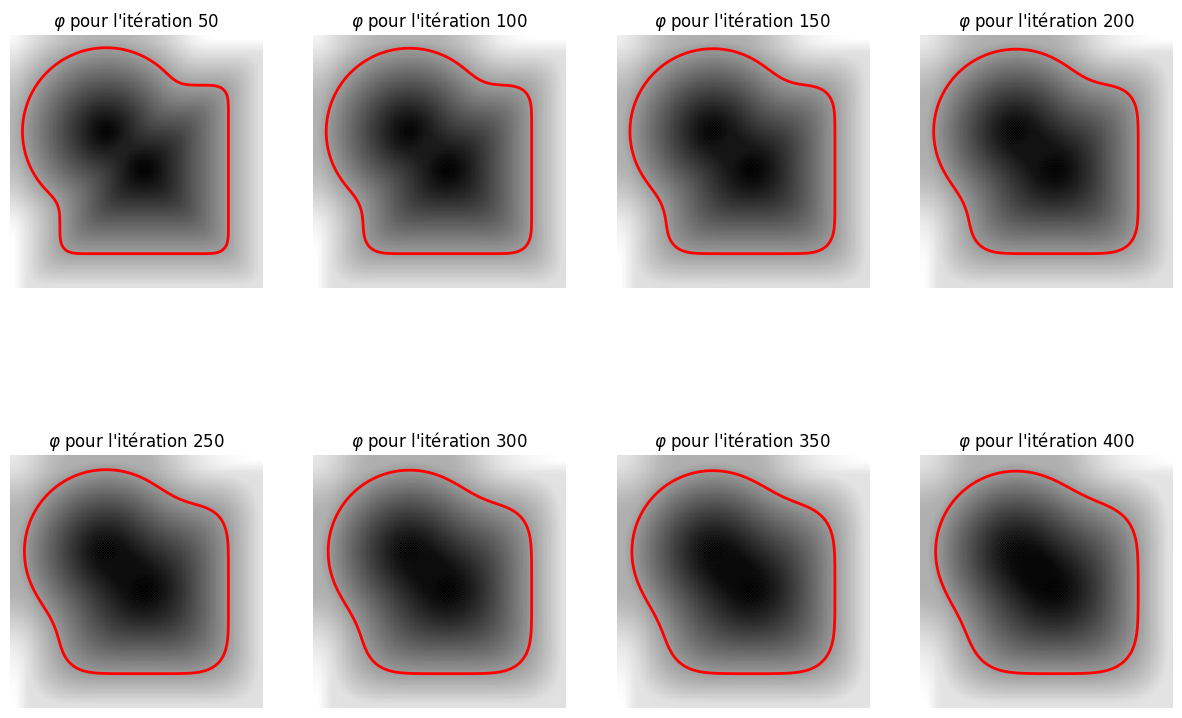

In [17]:
phi0_1 = np.minimum(phi1, phi2)
print("Descente de gradient en partant de l'union des deux formes : ")
gradientdescent(phi0_1,niter,tau,eps = np.finfo(float).eps)

Descente de gradient en partant de l'intersection des deux formes : 


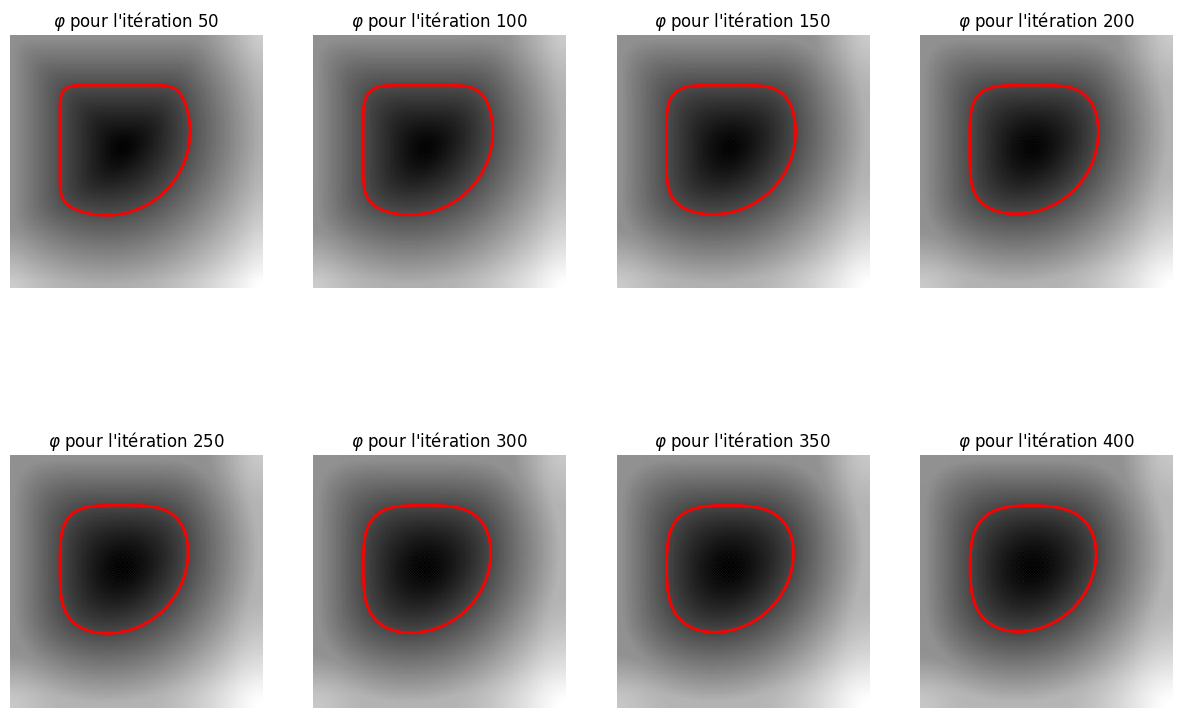

In [18]:
phi0_2 = np.maximum(phi1, phi2)
print("Descente de gradient en partant de l'intersection des deux formes : ")
gradientdescent(phi0_2,niter,tau,eps = np.finfo(float).eps)

<font color='blue'>
    
Commentaires : 
- On constate qu'à chaque étape de la descente de gradient, la courbe de niveau devient de plus en plus lisse.
- Au bout de seulement 50 itérations, le contour est déjà relativement régulier, les angles à l'intersection des deux formes se sont arrondis. 
- A la fin des 400 itérations, la courbe de niveau est très régulière. Les deux formes se sont fondues l'une dans l'autre et il devient difficile de distinguer que l'on partait de l'intersection ou de l'union entre un cercle et un carré. 
    
</font>

Levelset Re-distancing
----------------------
During PDE resolution, a level set function $\phi$ might become
ill-conditionned, so that the zero crossing is not sharp enough.
The quality of the level set function is restored by computing the
signed distance function to the zero level set.



This corresponds to first extracting the zero level set
$$ \Cc = \enscond{x \in \RR^2 }{\phi(x)=0},  $$
and then solving the following eikonal equation PDE on $\tilde \phi$
(in viscosity sense)
$$ \norm{\nabla \tilde \phi(x)} = 1
      \qandq \forall y \in \Cc, \tilde\phi(y)=0. $$
The one can replace $\phi$ by $\text{sign}(\phi(x))\tilde \phi(x)$
which is the signed distance function to $\Cc$.


We set $\phi=\phi_0^3$ so that they are both valid level set function
of the same curve, but $\phi$ is not the signed distance function.

<font color='blue'> Une des propriétés essentielles de la fonction $\varphi$ est la localisation de ses lignes de niveaux et en particulier de la ligne de niveau nulle. Pour éviter que la fonction $\varphi$ soit **mal conditionnée** (i.e le changement de signe n'est pas assez marqué) lors de la résolution de l'EDP, on impose à $\varphi$ d'être une fonction distance signée $||\nabla \varphi|| = 1$. Cependant, cette propriété n'est généralement pas préservée par l'évolution des courbes de niveaux. Faire du levet-set redistancing permet de retrouver cette propriété sans modifier la localisation de la courbe de niveau nulle. 
On effectue les étapes suivantes : 

<font color='blue'> 1) On initialise une fonction de distance non signée dont on veut conserver les lignes de niveaux $\varphi$, càd $ C = \{x \in \mathbb{R}^2,  \varphi(x)=0 \}$ . On peut l'initialiser à $\varphi_0^3$, ce qui permet de conserver le signe de $\varphi$, mais garantit d'avoir un gradient plus fort (modifier le gradient au voisinage de 0).

<font color='blue'> 2) On effectue un redistancing pour trouver $\tilde \varphi (x)$, telle qu'elle soit une fonction de distance signée, c'est-à-dire que $$ \norm{\nabla \tilde \phi(x)} = 1$$
 tout en préservant les lignes de niveaux c'est-à-dire 
    $$\left\{x \in \mathbb{R}^n | \varphi(x)=0 \right\}  = \left\{x \in \mathbb{R}^n | \tilde \varphi(x)=0 \right\}$$
On utilise l'algorithme **Fast marching method** (FMM) pour résoudre l'équation eikonale par rapport à $\tilde \varphi$ telle que :

<font color='blue'>
\begin{equation}
\left\{ 
    \begin{array}{ll}
        ||\nabla \tilde \varphi (x) || = 1 \\ 
        \forall y \in C, \tilde \varphi (y) = 0 
    \end{array}
\right. 
\end{equation}

In [19]:
pip install scikit_fmm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


<font color='blue'> On initialise le level set de départ :

In [20]:
phi = phi0**3

Solve the eikonal PDE using the Fast Marching algorithm. You have to install a C++ compiler (https://wiki.python.org/moin/WindowsCompilers#Microsoft_Visual_C.2B-.2B-_14.0_standalone:_Visual_C.2B-.2B-_Build_Tools_2015_.28x86.2C_x64.2C_ARM.29) and the package scikit-fmm (skfmm) to run this function (pip install scikit_fmm in the console).

<font color='blue'> On fait le redistancing du level set de départ :

In [21]:
from nt_toolbox.perform_redistancing import *
phi1 = perform_redistancing(phi0)

Display the level sets.

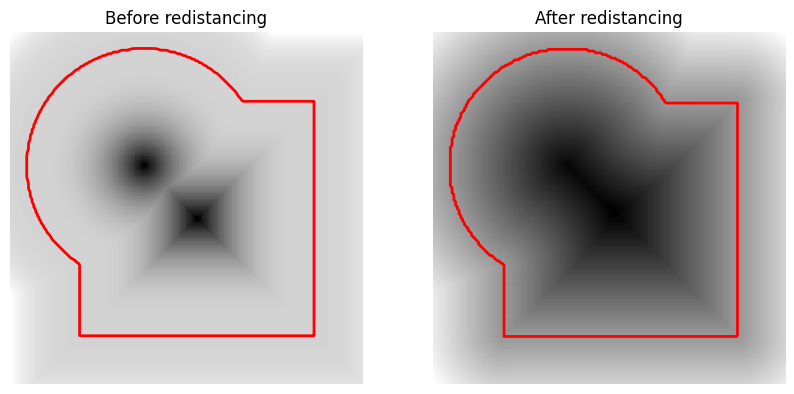

In [22]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plot_levelset(phi)
plt.title("Before redistancing")

plt.subplot(1,2,2)
plot_levelset(phi1)
plt.title("After redistancing")

plt.show()

<font color='blue'> **Commentaires :**
On observe qu'après l'opération de redistanciation, $\varphi$ est mieux conditionnée car le changement de signe est plus marqué. En effet, sur la figure présentant les lignes de niveau avant la redistanciation, on constate qu'à l'intérieur du carré de nombreuses lignes de niveau sont très claires (ce qui signifie qu'elles sont proches de 0). Seules les lignes de niveaux les plus proches du centre sont éloignées du 0. A l'inverse, sur la figure présentant les lignes de niveau après la redistanciation, les lignes de niveau à l'intérieur du carré sont plus sombres et ne deviennent blanche qu'au niveau du contour, c'est à dire que le changement de signe est plus marqué. De plus, il est important de remarquer que la courbe de niveau 0 a été conservée après l'opération de redistanciation. 

Edge-based Segmentation with Geodesic Active Contour
----------------------------------------------------
Geodesic active contours compute loval minimum of a weighted geodesic
distance that attract the curve toward the features of the background
image. The geodesic active contour minimizes a weighted length of curve
$$ \umin{\ga} \int_0^1 \norm{\ga'(s)} W(\ga(s)) d s $$



_Note:_ these active contours should not be confounded with the geodesic shortest paths,
that are globally minimizing geodesics between two points.
Here the active contour is a close curve progressively decreasing a
weighted geodesic length that is only a local minimum
(the global minimum would be a single point).


Given a background image $f_0$ to segment, one needs to compute
an edge-stopping function $W$.
It should be small in area of high gradient, and high in area of small gradient.


We use here
$$ W(x) = \al + \frac{\be}{\epsilon + d(x) }
      \qwhereq d = \norm{\nabla f_0} \star h_a, $$
and where $h_a$ is a blurring kernel of size $a>0$.


Compute the magnitude of the gradient $d_0(x) = \norm{\nabla f_0(x)}$.

<font color = "blue"> L'approche par contour géodésiques actifs est similaire à l'approche par contours actifs, à la différence que la fonction perte est pondérée par une fonction $W$ qui prend en compte les caractéristiques de l'image initiale. 
    
<font color = "blue"> L'objectif est de minimiser la "weighted length" : 
 
<font color = "blue"> $$L(t) =  \int_0^1 \|{\gamma'(s)}\| W(\gamma(s)) d s $$

<font color = "blue"> **Principe général :** On part d'une image $f_0$ en noir et blanc que l'on veut segmenter. Les contours actifs géodésiques ont pour but de calculer une fonction de détection de contour $W$. La présence d'un contour est caractérisée par un changement brutal de valeur des pixels de l'image.
    
<font color = "blue"> La fonction de détection de contours $W$
    
- <font color = "blue"> a des valeurs élevées aux endroits où il y a des faibles gradients, c'est-à-dire aux endroits où il n'y a pas de contour.
    
- <font color = "blue"> a des valeurs faibles aux endroits où il y a de forts gradients, donc au passage du contour.
    
<font color = "blue">    W est définie par : 

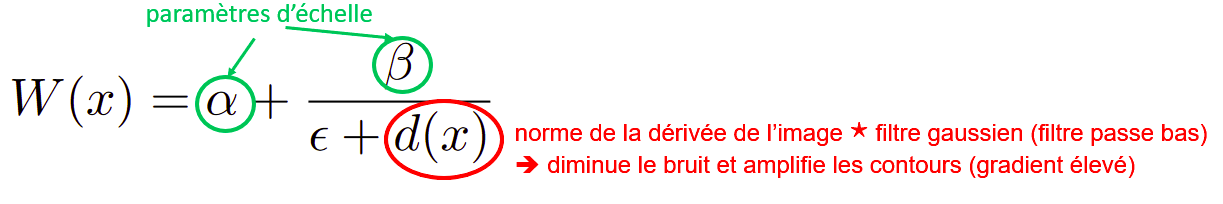

<font color = "blue"> On définit la taille de l'image : 

In [23]:
n = 200

<font color = "blue"> On charge l'image de départ $f_0 \in \RR^{n \times n}$, que l'on veut segmenter.

In [24]:
f0 = rescale(load_image("nt_toolbox/data/cortex.bmp", n)) #rescale entre 0 et 1 l'image 

<font color = "blue"> On calcule le gradient et sa norme :

In [25]:
g = grad(f0, order=2) #calcule du gradient (a une taille de (200, 200, 2) pour les dérivées verticales et horizontales)
d0 = np.sqrt(np.sum(g**2, 2)) #norme du gradient 

<font color = "blue">  On définit la taille du filtre de floutage $a$ :

In [26]:
a = 5

<font color = "blue">  On calcule le filtre de floutage $d = d_0 \star h_a$ :

In [27]:
from nt_toolbox.perform_blurring import *
d = perform_blurring(d0, np.asarray([a]),bound="per") #fait la convolution avec un filtre gaussien de notre norme de gradient 

[200 200]


<font color = "blue"> On définit le paramètre $\epsilon>0$ :

In [28]:
epsilon = 1e-1

<font color = "blue"> On définit les paramètres $\al$ et $\be$ pour ajuster les valeurs de $W$ (de manière équivalente, on utilise la fonction de renormalisation).

In [29]:
W = 1./(epsilon + d)
W = rescale(-d, 0.1, 1) #équivalent à la ligne précédente, permet d'avoir des valeurs faibles là où il y a des fortes valeurs de gradients et vice versa. 

Display it.

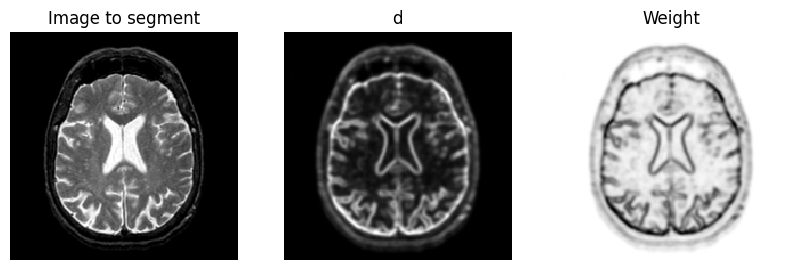

In [30]:
plt.figure(figsize=(10,5))
imageplot(f0, "Image to segment", [1,3,1])
imageplot(d, "d", [1,3,2])
imageplot(W, "Weight", [1,3,3])

<font color = "blue">  On rappelle que $d$ correspond à faire une convolution de l'image originale (l'image du cerveau) par un filtre de convolution passe bas. Ce filtre a pour caractéristique de diminuer le bruit et d'amplifier les valeurs correspondant aux contours. $d$ a donc des valeurs faibles (proche de 0, affichées en noir) en dehors des zones de contour. 

<font color = "blue"> On calcule $W$ grâce à deux paramètres d'echelle, ce qui permet d'obtenir des valeurs élevées pour les gradients faibles (affichés en blanc), et les valeurs correspondant aux contours avec des valeurs élevées (affichés en noir). L'image a donc été bien segmentée, ses contours ressortent bien en noir sur l'image weight (à droite).

__Exercise 4__

<font color = "blue">  On définit la forme du level set initial. On prend un carré, que l'on superpose à l'image du cerveau. 
    
Compute an initial shape $\phi_0$ at time $t=0$,
for instance a centered square.

In [31]:
phi0= np.maximum(abs(X-int(X.shape[0]/2)), abs(Y-int(Y.shape[0]/2)))- r

Display it.

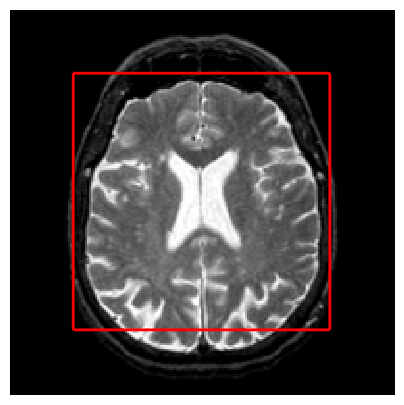

In [32]:
plt.figure(figsize=(5,5))
plot_levelset(phi0, 0, f0) #plot levelset prend un argument pour mettre une image en arrière plan

<font color = "blue">  On rapelle qu'on veut minimiser : 

<font color = "blue"> 
\begin{equation}
\min_{\gamma} \int_0^1 \|{\gamma'(s)}\| W(\gamma(s)) d s 
\end{equation}

<font color = "blue">  On calcule le gradient : 

<font color = "blue">  $$ \frac{\partial{\phi_t}}{\partial{t}} = G(\phi_t) \
\rm{avec} \ G(\phi) = -\|\nabla \phi\| \text{div}\pa{
          W \frac{\nabla \phi}{\|{\nabla \phi}\|}
  } $$

<font color = "blue">  On peut le ré écrire $$ G(\phi) = -W \norm{\nabla \phi} \text{div} \pa{ \frac{\nabla \phi}{\norm{\nabla \phi}}  } - \dotp{\nabla W}{\nabla \phi} $$

<font color = "blue">  On réalise une descente de gradient : 
$$ \phi^{(\ell+1)} = \phi^{(\ell)} - \tau G(\phi^{(\ell)}), $$

<font color = "blue">  où le pas $\tau>0$ est suffisamment petit. 


<font color = "blue"> On définit les éléments dont on aura besoin pour faire la descente de gradient.

<font color = "blue">  On définit le pas :

In [33]:
tau = .4

<font color = "blue"> On définit le nombre maximal d'itérations et le temps final : 

In [34]:
Tmax = 1500
niter = int(Tmax/tau)

<font color = "blue">  On initialise le level set de départ $\phi^{(0)}=\phi_0$ :

In [35]:
phi = np.copy(phi0)

<font color = "blue">  On précalcule $\nabla W$ :

In [36]:
gW = grad(W, order=2)

__Exercise 5__

Compute and store in G the gradient $G(\phi)$ (right hand side of the PDE)
using the current value of the distance function $\phi$.

<font color = "blue"> On calcule $G(\phi)$ :

In [37]:
# calcul du gradient de phi :
g0 = grad(phi, order=2)

# calcul de la norme du gradient en évitant les 0 :
d = np.maximum(eps*np.ones([n,n]), np.sqrt(np.sum(g0**2, 2)))

# g = grad(phi)/|grad(phi)| :
g = g0/np.repeat(d[:,:,np.newaxis], 2, 2) # on renormalise le gradient
K = - d*div(g[:,:,0], g[:,:,1], order=2) # calcul du gradient (c'est la dérivé de phi)

# <grad W, grad phi>
scalar_product = gW[:,:,0]*g0[:,:,0]+gW[:,:,1]*g0[:,:,1] 

# calcul de G(phi)
G = W*d*K-scalar_product

<font color = "blue">  Un pas de descente de gradient :

In [38]:
phi = phi - tau*G

<font color = "blue">  De temps en temps (par exemple toutes les 30 itérations), on fait un  re-distancing de $\phi$.

In [39]:
phi = perform_redistancing(phi)

__Exercise 6__

Implement the geodesic active contours gradient descent.
Do not forget to do the re-distancing.

<font color = "blue"> On reprend les étapes dans l'ordre pour créer une fonction qui fait la descente de gradient géodésique :

In [40]:
def geodesicgradientdesecent(phi0,niter,eps = np.finfo(float).eps):
    plt.figure(figsize=(15,10))
    gW = grad(W, order=2)
    phi = np.copy(phi0)
    k = 0
    tau = .4
    n_dist = 30
    for i in range(1,niter+1):
        g0 = grad(phi, order=2)
        d = np.maximum(eps*np.ones([n,n]), np.sqrt(np.sum(g0**2, 2))) #calcul de la norme du gradient en évitant les 0
        # g = grad(phi)/|grad(phi)
        g = g0/np.repeat(d[:,:,np.newaxis], 2, 2) # on renormalise le gradient
        K = - div(g[:,:,0], g[:,:,1], order=2) # calcul du gradient (c'est la dérivé de phi)
        # <grad W, grad phi>
        scalar_product = gW[:,:,0]*g0[:,:,0] + gW[:,:,1]*g0[:,:,1] 
        G = W*d*K - scalar_product

        # une étape de desente de gradient :
        phi =  phi - tau*G 
        if i% 30==0:
            phi = perform_redistancing(phi)
        if i % int(niter/6.) == 0:
            k = k + 1        
            ax = plt.subplot(2, 3, k)
            ax.set_title(r"$\varphi$ pour l'itération "+ str(i))
            plot_levelset(phi, f=f0)

<font color = "blue"> Nous testons la descente de gradient en partant de différents $\phi_0$ :

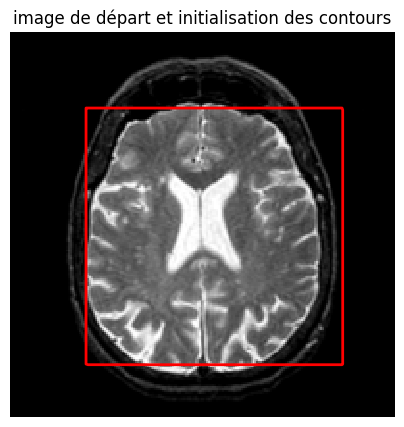

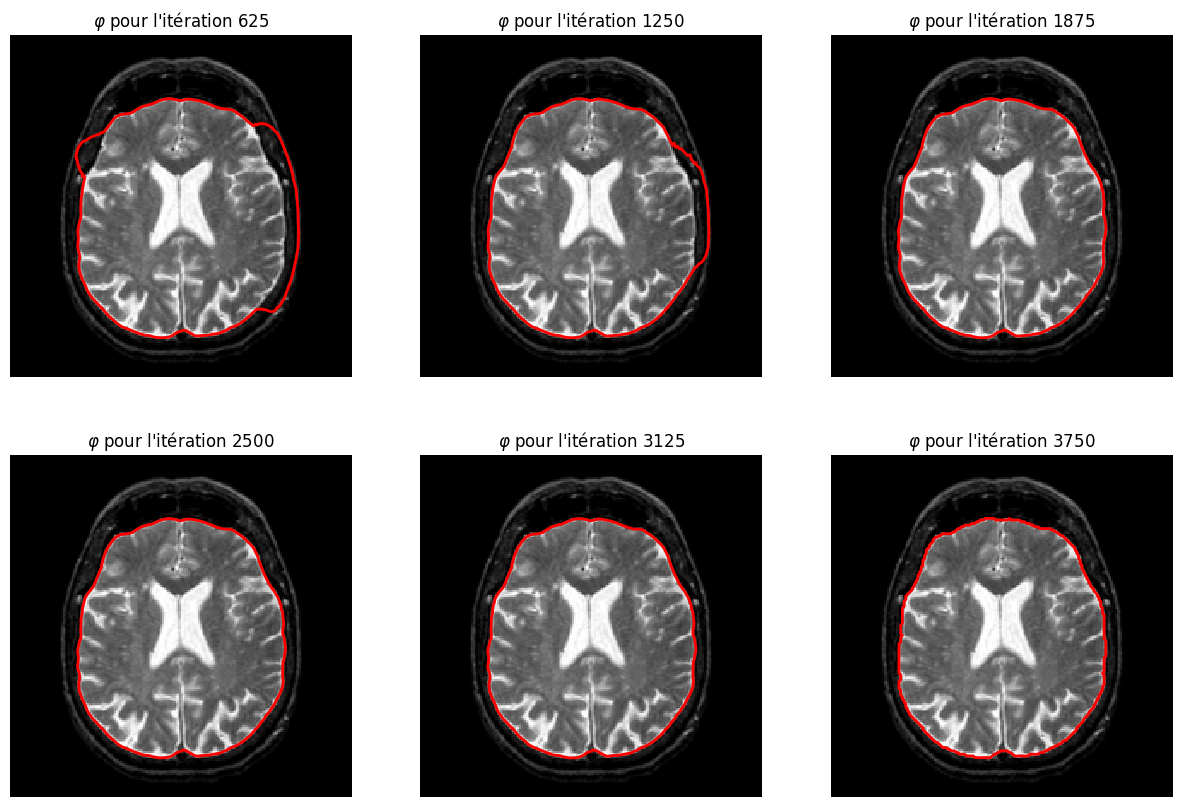

In [41]:
## En partant d'un carré : 
phi0 =  np.maximum(abs(X-c2[0]), abs(Y-c2[1])) - r
plt.figure(figsize=(5,5))
plt.title("image de départ et initialisation des contours")
plot_levelset(phi0, 0, f0) #plot levelset prend un argument pour mettre une image en arrière plan

Tmax = 1500
niter = int(Tmax/tau)
geodesicgradientdesecent(phi0,niter,eps = np.finfo(float).eps)

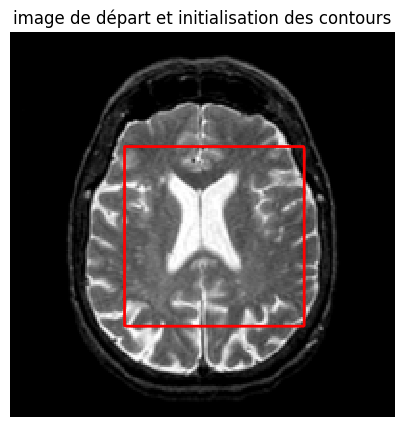

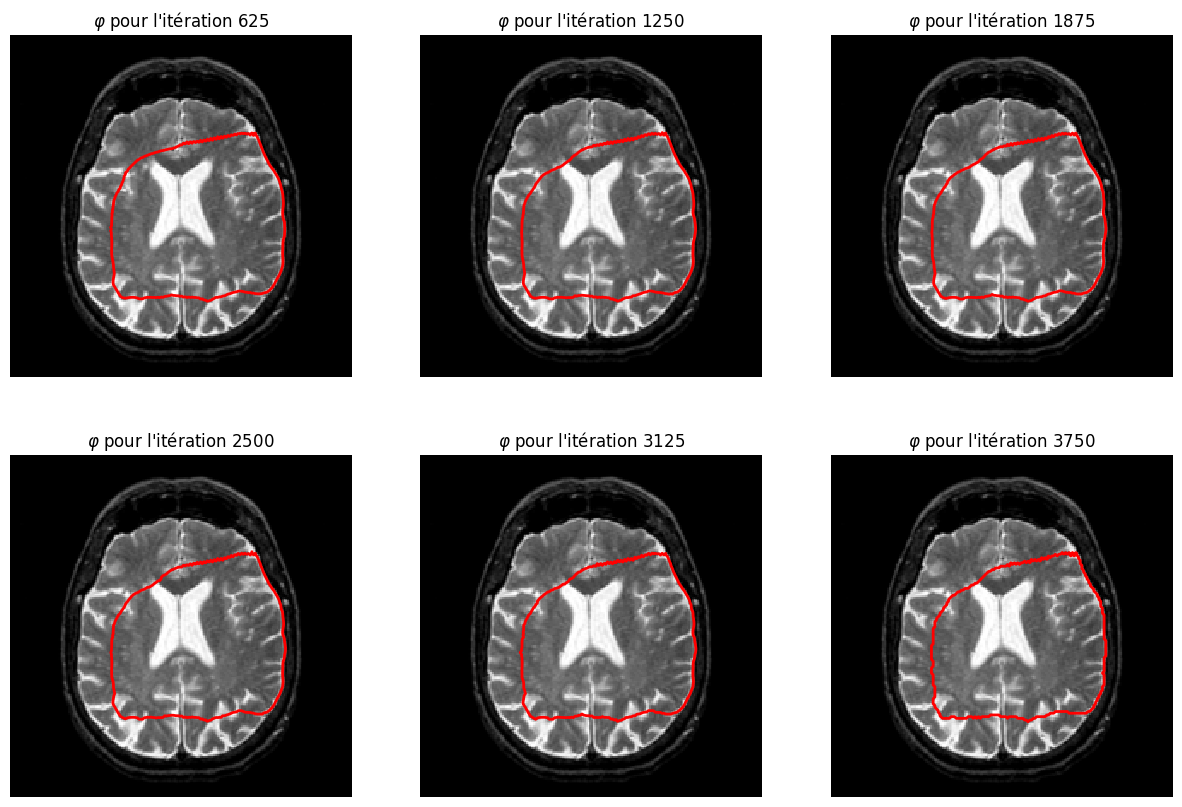

In [42]:
## Avec un carré plus petit :
phi0 =  np.maximum(abs(X-c2[0]), abs(Y-c2[1])) - (r-20)
plt.figure(figsize=(5,5))
plt.title("image de départ et initialisation des contours")
plot_levelset(phi0, 0, f0) #plot levelset prend un argument pour mettre une image en arrière plan

Tmax = 1500
niter = int(Tmax/tau)
geodesicgradientdesecent(phi0,niter,eps = np.finfo(float).eps)

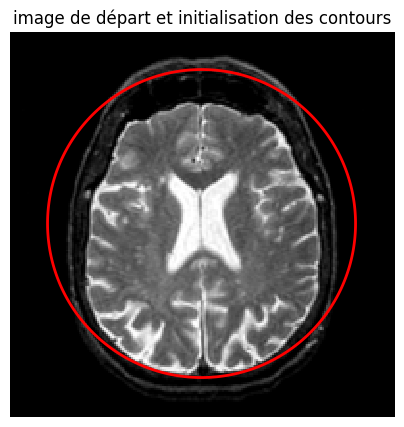

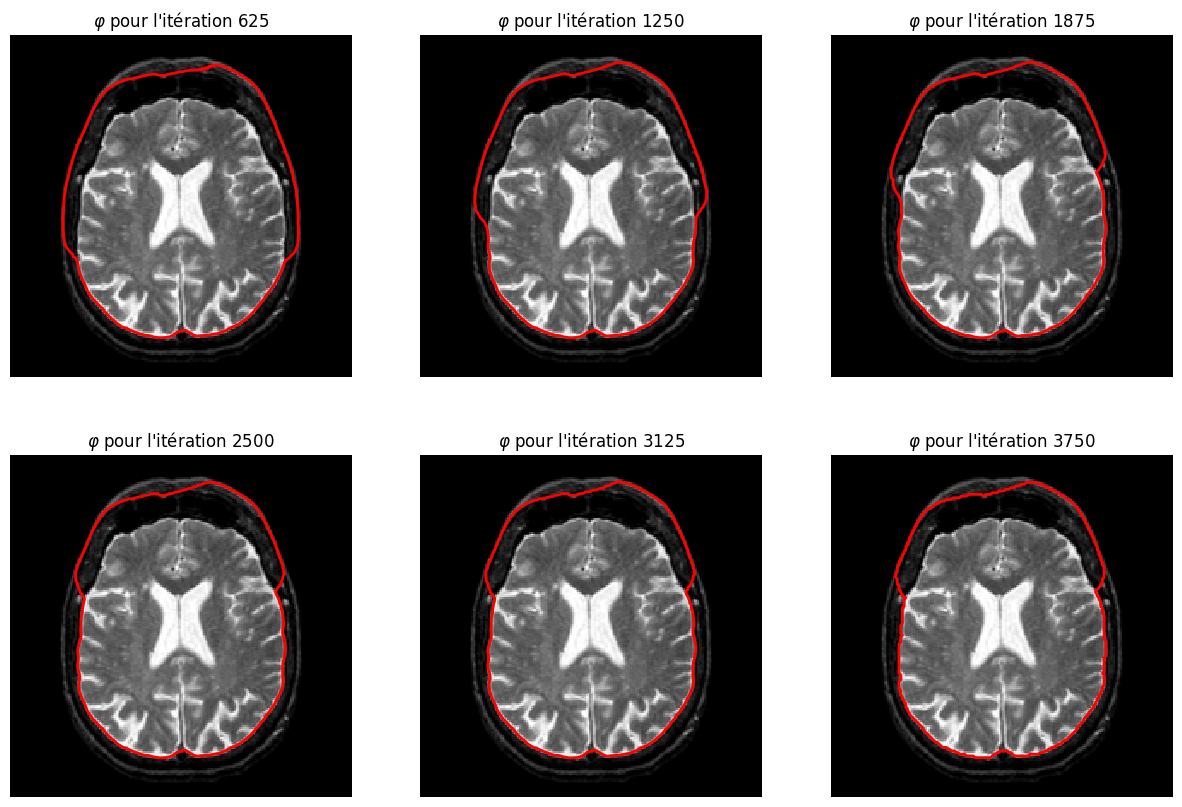

In [43]:
## En partant d'un cercle
phi0 = np.sqrt((X-int(X.shape[0]/2))**2 + (Y-int(X.shape[0]/2))**2) - 80
plt.figure(figsize=(5,5))
plt.title("image de départ et initialisation des contours")
plot_levelset(phi0, 0, f0) #plot levelset prend un argument pour mettre une image en arrière plan

Tmax = 1500
niter = int(Tmax/tau)
geodesicgradientdesecent(phi0,niter,eps = np.finfo(float).eps)

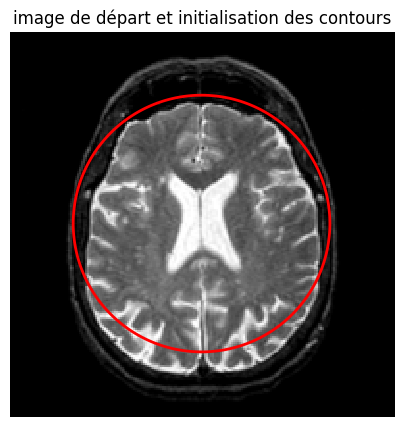

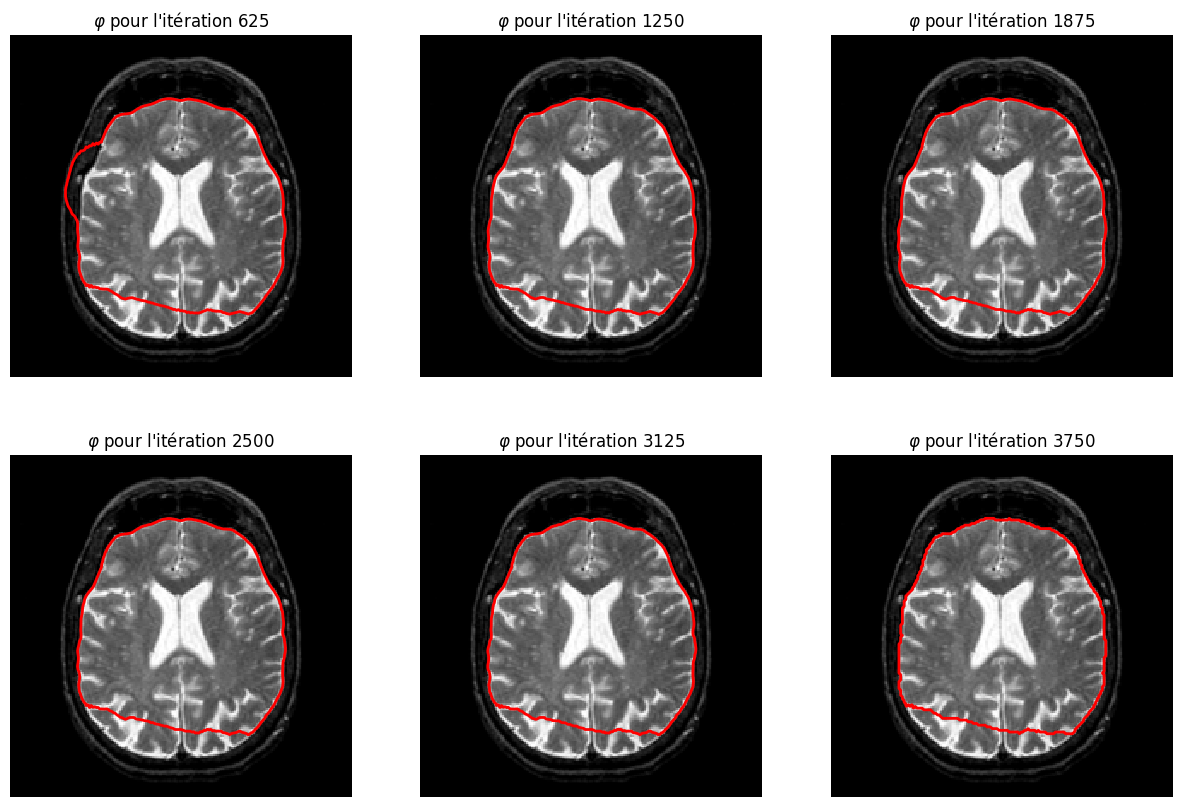

In [44]:
## En partant d'un cercle plus petit
phi0 = np.sqrt((X-int(X.shape[0]/2))**2 + (Y-int(X.shape[0]/2))**2) - r
plt.figure(figsize=(5,5))
plt.title("image de départ et initialisation des contours")
plot_levelset(phi0, 0, f0) #plot levelset prend un argument pour mettre une image en arrière plan

Tmax = 1500
niter = int(Tmax/tau)
geodesicgradientdesecent(phi0,niter,eps = np.finfo(float).eps)

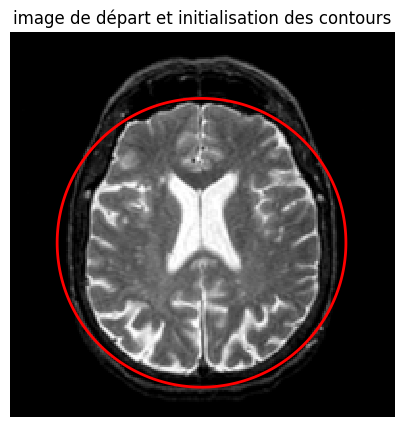

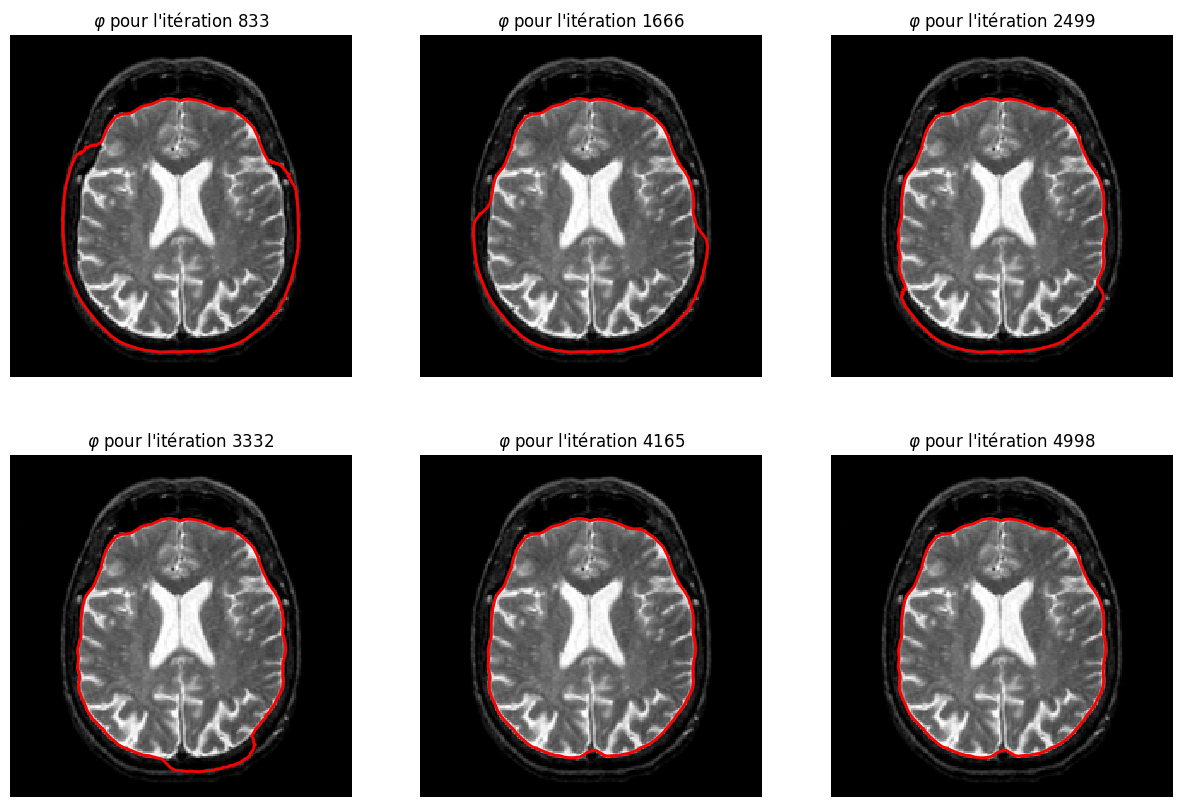

In [45]:
## En partant d'un cercle bien centré sur la zone à contourer :
phi0 = np.sqrt((X-int(X.shape[0]/2+10))**2 + (Y-(int(X.shape[0]/2)))**2) - 75
plt.figure(figsize=(5,5))
plt.title("image de départ et initialisation des contours")
plot_levelset(phi0, 0, f0) #plot levelset prend un argument pour mettre une image en arrière plan
Tmax = 2000
niter = int(Tmax/tau)
geodesicgradientdesecent(phi0,niter,eps = np.finfo(float).eps)

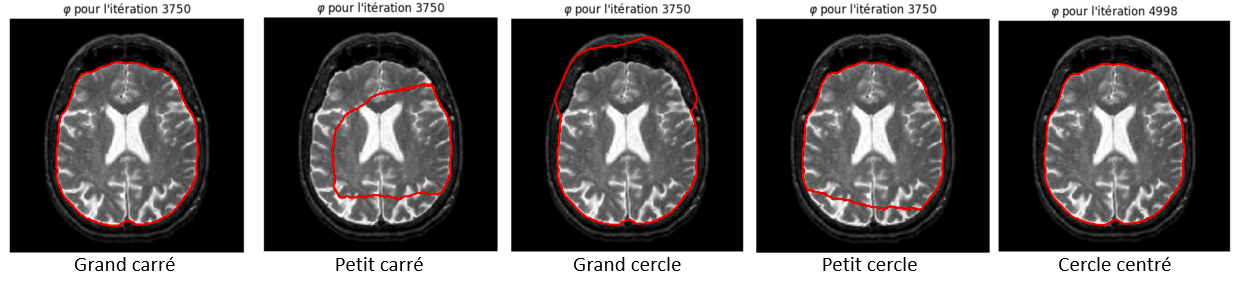

<font color='blue'> **Commentaires :**
    
    
<font color='blue'>    - En partant d'un carré comme contour initial, qui englobe parfaitement l'image, on voit que l'algorithme arrive à retrouver les contours quasiment parfaitement. 
    
<font color='blue'>    - Si le carré (ou le cercle) est trop large autour de l'objet dont on veut extraire les contours, alors l'algorithme converge vers un contour qui ne correspond pas à celui de l'image de départ. Augmenter le nombre d'itérations ne résout pas ce problème.
    
<font color='blue'>    - Si le carré (ou le cercle) se trouve à l'intérieur de l'image dont on voulait originellement extraire les contours, l'algorithme converge vers un contour qui ne correspond pas à celui de l'image de départ. Ce problème n'est pas résolu en augmentant le nombre d'itérations. 

<font color='blue'> - Si on part d'un cercle bien initialisé, plus d'itérations sont nécessaires pour converger en comparaison avec le carré, ce qui peut être dû au fait que dans notre cas, la zone de contour était plus proche d'un carré que d'un cercle. 


<font color='blue'>  On voit que cet algorithme est très sensible à l'initialisation du contour, ce qui peut perturber la convergence vers le bon contour. 
    
    

Region-based Segmentation with Chan-Vese 
-----------------------------------------
Chan-Vese active contours corresponds to a region-based energy
that looks for a piecewise constant approximation of the image.


The energy to be minimized is
$$ \umin{\phi}
      L(\phi) +
      \la \int_{\phi(x)>0} \abs{f_0(x)-c_1}^2 d x   +
      \la \int_{\phi(x)<0} \abs{f_0(x)-c_2}^2 d x
$$
where $L$ is the length of the zero level set of $\phi$.
Note that here $(c_1,c_2) \in \RR^2$ are assumed to be known.



<font color='blue'>  **Explications sur l'algorithme de segmentation de Chan-Vese:** 
    
<font color='blue'> L'algorithme de segmentation de Chan-Vese est conçu pour segmenter des objets sans frontières clairement définies. L'algorithme détecte le contour qui sépare l'objet de l'arrière plan sur une image.

<font color='blue'> Soit $f_0$, une image que l’on veut segmenter. Dans le cas où $f_0$ est une fonction constante par morceaux (ici $f_0$ est en noir et blanc), Chan et Vese ont proposé une approche par contour actif pour la segmentation d'images en deux phases.
L'idée est de rechercher une partition particulière de l'image $f_0$ en deux régions. La première région représente les objets à détecter dans l'image et la deuxième région représente l'arrière-plan de l'image. Ainsi, pour une image donnée $f_0$, on minimise la fonction énergie suivante: 

<font color='blue'> $\begin{equation} 
\min_{\varphi} E = \min_{\varphi} \left( L(\varphi) + \lambda \underbrace{\int_{\varphi(x) <0=int(C)} |f_0(x) - c_1|^2 dx}_{A} + \lambda \underbrace{\int_{\varphi(x) >0=out(C)} |f_0(x) - c_2|^2 dx}_{B} \right)
\end{equation}$


<font color='blue'> où $C$ représente le contour de l'objet (i.e. $C$ est la courbe de niveau nulle). 
    
- <font color='blue'>  Les constantes ($c_1,c_2$) $\in \mathbb{R}^2$ supposées connues, désignent respectivement les intensités moyennes à l'intérieur et à l'extérieur de la courbe. 
- <font color='blue'> Le terme $A$ correspond à la somme des différences d'intensité par rapport à la valeur moyenne à l'intérieur de la région segmentée.
- <font color='blue'> Le terme $B$ correspond à la somme des différences d'intensité par rapport à la valeur moyenne à l'extérieur de la région segmentée. 

<font color='blue'>  Ces deux intégrales sont pondérés par des coefficients $\lambda$ fixes.
- <font color='blue'> Enfin, le terme de régularisation $L(\varphi)$ représente la longueur de la courbe de niveau nulle ( = longueur de la région segmentée) et permet de contrôler le caractère lisse de la frontière $C$. 

<font color='blue'> L'algorithme Chan-Vese est basé sur des ensembles de niveaux qui évoluent de manière itérative pour minimiser l'énergie $E$. Le temps $t$ est artificiel et sert uniquement à décrire l'évolution des courbes de niveau au travers des itérations. 


<font color='blue'> Minimiser $E$ revient à résoudre: $\begin{equation}
\frac{\delta \varphi}{\delta t} = -G(\varphi_t)~~~
avec ~~~ G(\varphi) = -W||\nabla \varphi|| div \left( \frac{\nabla \varphi}{|| \nabla \varphi||} \right) + \lambda(f_0 - c_1)^2 - \lambda(f_0 - c_2)^2
\end{equation}$


<font color='blue'> Pour résoudre cette équation, on réalise une descente de gradient: 

<font color='blue'> $$ \varphi_t^{(\ell+1)} = \varphi_t^{(\ell)} - \tau G(\varphi_t^{(\ell)}), $$

__Exercise 7__

Compute an initial level set function $\phi_0$, stored in phi0,
for instance many small circles.

<font color='blue'> Contrairement au cas de l'intersection ou de l'union du carré et du cercle, on en connait pas le level set initial. On va donc instancier une grille régulière de petits cercles de manière à couvrir l'image. 

un exemple de cercles de rayon 0.4


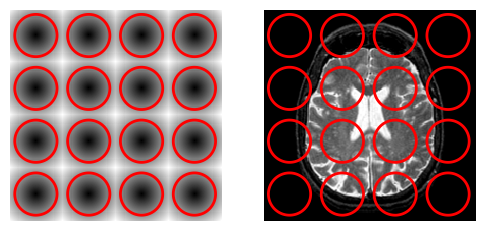

un exemple de cercles de rayon 0.2


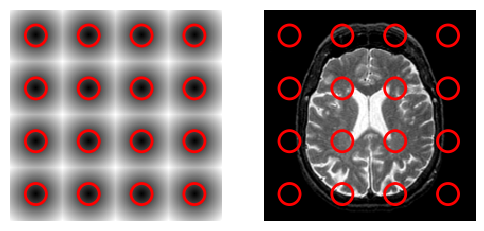

In [46]:
## Insert your code here.
def creer_cercles(ratio_rayon = 0.4) : 
    # grille de taille n*n : 
    Y,X = np.meshgrid(np.arange(1,n+1), np.arange(1,n+1)) 
    
    # 4 cercles par coté sur l'image :
    n_cercles = 4 
    
    # on découpe l'image en cellules qui contiennent chacune un cercle et sont donc de taille n/n_cercles :
    cell = n/n_cercles 
    
    # rayon d'un cercle : défini de manière à ce que les cercles ne se chevauchent pas
    rayon = ratio_rayon*cell
    
    # on définit phi0 à une valeur maximale de manière à pouvoir rajouter un cercle dans la grille à chaque itération
    phi0 = np.zeros([n,n])+np.float("inf") 
    
    for i in range(0,n_cercles):
        for j in range(0,n_cercles):
            # on définit les coordonnées du centre du cercle : 
            c = (np.array([i,j])+0.5)*cell # coordonnées de la position = centre de la cellule (i,j)
            phi0 = np.minimum(phi0,np.sqrt(abs(X-c[0])**2 + abs(Y-c[1])**2) - rayon)
    return phi0

print("un exemple de cercles de rayon 0.4")
phi0 = creer_cercles(ratio_rayon = 0.4)
plt.figure(figsize=(6,3))        
plt.subplot(1,2,1)
plot_levelset(phi0,0)
plt.subplot(1,2,2)
plot_levelset(phi0, 0, f0)
plt.show()
plt.close()

print("un exemple de cercles de rayon 0.2")
phi0 = creer_cercles(ratio_rayon = 0.2)
plt.figure(figsize=(6,3))        
plt.subplot(1,2,1)
plot_levelset(phi0,0)
plt.subplot(1,2,2)
plot_levelset(phi0, 0, f0)
plt.show()
plt.close()

<font color = "blue"> Plus on prend des cercles grands, plus la surface de l'image est bien recouverte par $\phi_0$. Pour que les cercles soient distincts il faut que le paramètre d'entrée ratio_rayon soit $< 0.5$.  Dans la suite on comparera les résultats que l'on obtient avec la descente de gradient de Chan Vese selon le $\phi_0$ de départ.

<font color = "blue"> On définit le paramètre $\la$

In [47]:
lambd = 2

<font color = "blue"> On définit les valeurs de $c_1,c_2$

In [48]:
c1 = .7
c2 = 0

<font color = "blue"> On définit le pas :

In [49]:
tau = .5

<font color = "blue"> On définit le nombre d'itérations :

In [50]:
Tmax = 100
niter = int(Tmax/ tau)

<font color = "blue"> On initialise le level set de départ $\phi_0$ au temps $t=0$.

In [51]:
phi = np.copy(phi0)


<font color = "blue"> Minimiser $E$ revient à résoudre: 
<font color = "blue"> $$\frac{\delta \varphi}{\delta t} = -G(\varphi_t)$$
avec  $G(\varphi) = -W||\nabla \varphi|| div \left( \frac{\nabla \varphi}{|| \nabla \varphi||} \right) + \lambda(f_0 - c_1)^2 - \lambda(f_0 - c_2)^2$

<font color = "blue"> Pour résoudre ce problème, on réalise une descente de gradient: 

<font color = "blue">
$$ \varphi_t^{(\ell+1)} = \varphi_t^{(\ell)} - \tau G(\varphi_t^{(\ell)}), $$


__Exercise 8__

Compute this gradient $G(\phi)$ using the current value of the distance function.

In [52]:
# gradient de phi : 
graD = grad(phi, order=2) 

#calcul de la norme du gradient en évitant les 0 :
d = np.maximum(eps*np.ones([n,n]), np.sqrt(np.sum(graD**2, 2))) 

# on renormalise le gradient
g = graD/np.repeat(d[:,:,np.newaxis], 2, 2)  

# calcul du gradient (c'est la dérivé de phi) :
K = - div(g[:,:,0], g[:,:,1], order=2) 

# calcul de G(phi)
G = K + lambd*(f0-c1)**2 - lambd*(f0-c2)**2

<font color = "blue"> Une étape de la descente de gradient :

In [53]:
phi = phi - tau*G

__Exercise 9__

Implement the full gradient descent.

<font color='blue'> En se basant sur les lignes de codes précédentes, on implémente la descente de gradient.

In [54]:
## Insert your code here.
# on crée une fonction qui performe une descente de gradient en partant de phi0 et avec un nombre d'itérations donné
def descente_gradient_chan_vese(phi0,niter) :
    plt.figure(figsize=(8,6))
    phi = np.copy(phi0)
    k = 0

    for i in range(1,niter+1):
        # g0 = grad(phi)
        graD = grad(phi, order=2) # mise à jour du gradient

        # d = |grad(phi)|
        d = np.maximum(eps*np.ones([n,n]), np.sqrt(np.sum(graD**2, 2))) #calcul de la norme du gradient en évitant les 0

        # g = grad(phi)/|grad(phi)
        g = graD/np.repeat(d[:,:,np.newaxis], 2, 2) # on renormalise le gradient

        # G = -d phi(t)/dt
        G = - div(g[:,:,0], g[:,:,1], order=2) + lambd*(f0-c1)**2 - lambd*(f0-c2)**2 # calcul du gradient (c'est la dérivé de phi)

        # une étape de desente de gradient :
        phi = phi - tau*G

        if i % 30 == 0:
            phi = perform_redistancing(phi) #faire du level set redistancing pour garantir un changement de signe assez marqué pour phi

        if i % int(niter/4.) == 0:
            k = k + 1        
            ax = plt.subplot(2, 2, k)
            ax.set_title(r"$\varphi$ pour l'itération "+ str(i))
            plot_levelset(phi, f=f0)

initialisation avec des cercles de rayon 0.4


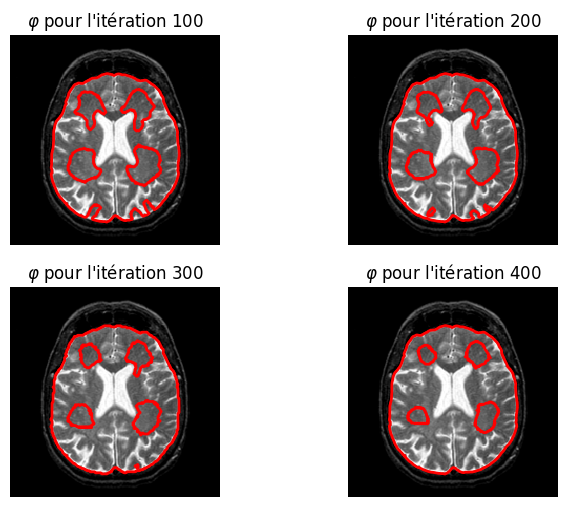

In [55]:
print("initialisation avec des cercles de rayon 0.4")
phi0 = creer_cercles(ratio_rayon = 0.4)
Tmax = 200
niter = int(Tmax/ tau)
descente_gradient_chan_vese(phi0,niter)

un exemple de cercles de rayon 0.3


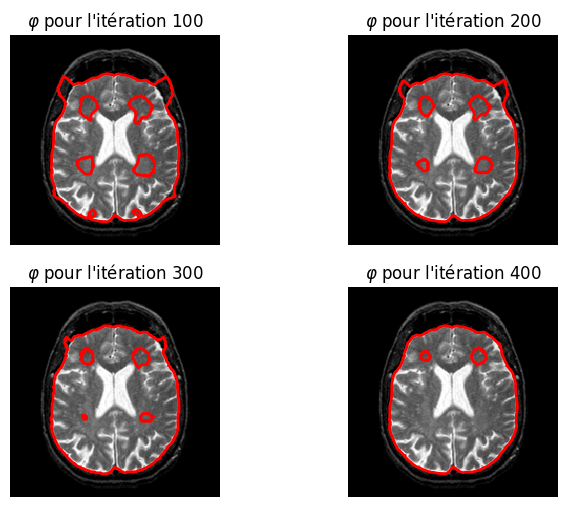

In [56]:
print("un exemple de cercles de rayon 0.3")
phi0 = creer_cercles(ratio_rayon = 0.3)
Tmax = 200
niter = int(Tmax/ tau)
descente_gradient_chan_vese(phi0,niter)

un exemple de cercles de rayon 0.2


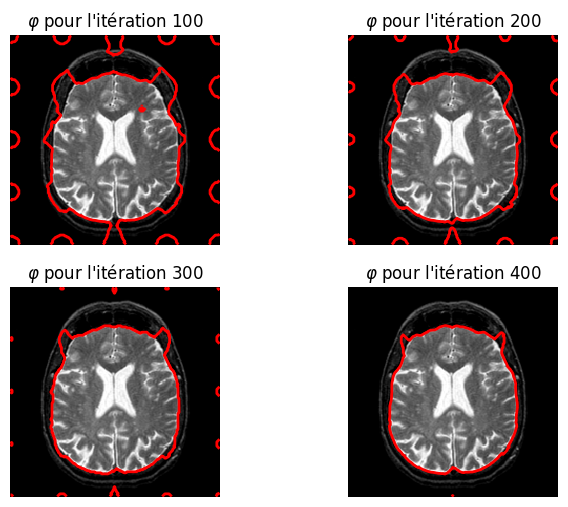

In [57]:
print("un exemple de cercles de rayon 0.2")
phi0 = creer_cercles(ratio_rayon = 0.2)
Tmax = 200
niter = int(Tmax/ tau)
descente_gradient_chan_vese(phi0,niter)

<font color = "blue"> **Commentaires :** 
- <font color = "blue"> On observe que plus les cercles définissant $\phi_0$ sont larges, plus l'algorithme converge rapidement sur le contour du cerveau. En effet, la segmentation que l'on obtient après 100 itérations est meilleure pour les cercles de rayons 0.4 ou 0.3 que 0.2.
- <font color = "blue"> Pour les cercles plus petits, il faut un nombre d'itération plus important pour obtenir une segmentation aussi satisfaisante que sur les cercles les plus gros. Par exemple, sur les cercles de rayons 0.2, après 300 itérations on voit encore des traces des cercles d'origine sur les bords de l'image, et après 400 itérations on a enfin une bonne segmentation du cerveau. 
- <font color = "blue"> Si on prend un rayon suffisamment large, on constate que l'algorithme segmente également des zones à l'intérieur du cerveau. C'est par exemple le cas pour un rayon de 0.4, où l'algo a délimité 4 zones à l'intérieur du cerveau.

<font color = "blue">  RESUME

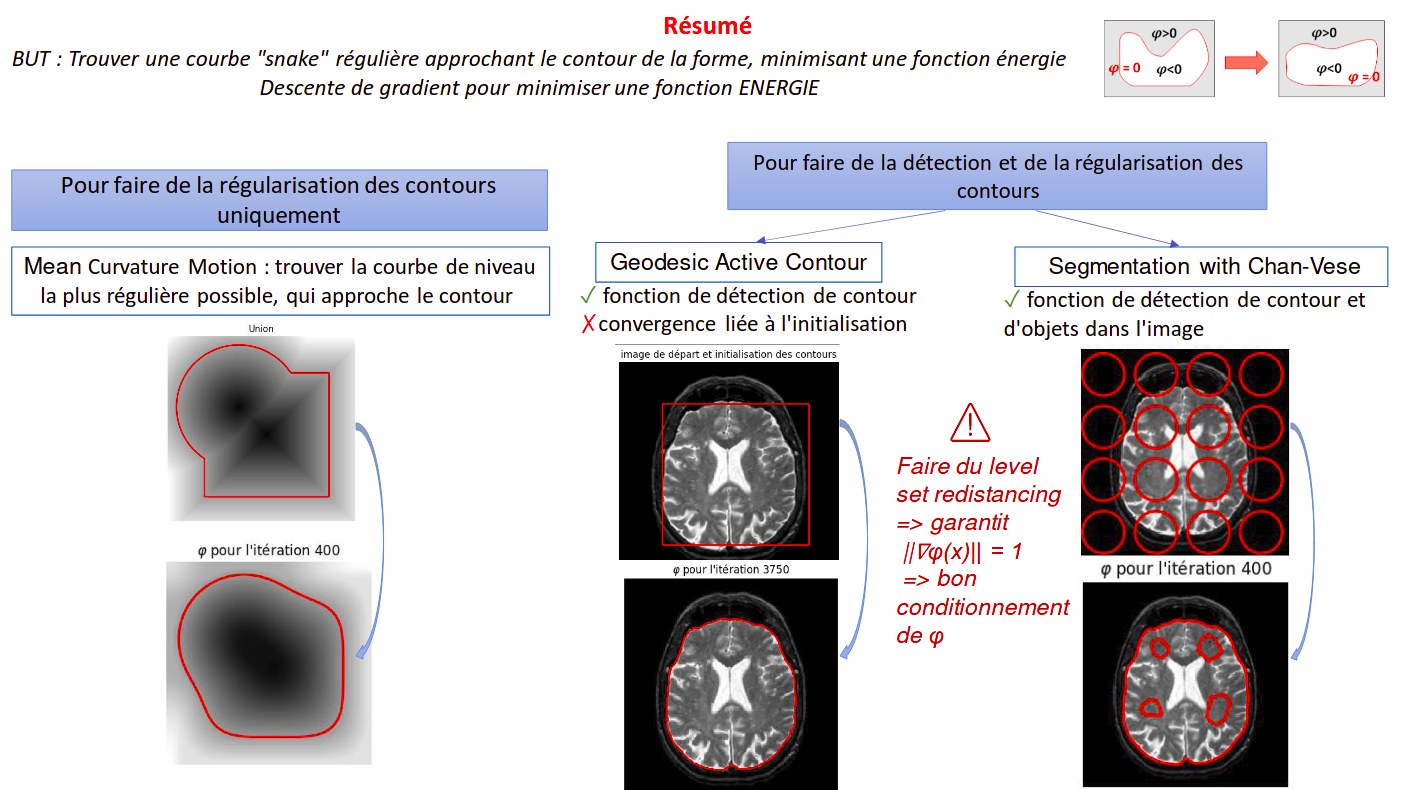